# Feature Engineering Notebook

### Objectives:

Engineer features for Classification, Regression and Cluster models

### Inputs:

outputs/datasets/cleaned/cleanedDataset.csv

### Outputs:

generate a list with variables to engineer

### 1. Import libraries and get the current directory path

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
import scipy.stats as stats
import warnings

# Set styles
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# In case you want to go one directory back
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))

### 2. Check the data

In [4]:
df = pd.read_csv(f"outputs/datasets/cleaned/cleanedDataset.csv")
df['published_timestamp'] = pd.to_datetime(df['published_timestamp'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   course_id            3672 non-null   int64              
 1   course_title         3672 non-null   object             
 2   url                  3672 non-null   object             
 3   is_paid              3672 non-null   int64              
 4   price                3672 non-null   int64              
 5   num_subscribers      3672 non-null   int64              
 6   num_reviews          3672 non-null   int64              
 7   num_lectures         3672 non-null   int64              
 8   level                3672 non-null   object             
 9   content_duration     3672 non-null   float64            
 10  published_timestamp  3672 non-null   datetime64[ns, UTC]
 11  subject              3672 non-null   object             
dtypes: datetime64[ns, UT

### 3. Split Dataset into Train and Test

In [6]:
# Split the dataset into train and test
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# Verify the shape of train and test datasets
train_set.shape, test_set.shape

((2937, 12), (735, 12))

### 4. Feature Engineering for Categorical Variables

In [9]:
# Select categorical variables for encoding
categorical_vars = ['course_title', 'level', 'subject']  # example categorical columns

# Create a copy of the train set with only categorical variables
df_cat = train_set[categorical_vars].copy()

# Apply Ordinal Encoding
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_vars)
train_set_encoded = encoder.fit_transform(train_set)
test_set_encoded = encoder.transform(test_set)

# Display the transformed train dataset
train_set_encoded.head(3)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
978,467238,0,https://www.udemy.com/advance-technical-analysis/,1,50,152,6,14,0,3.5,2015-04-08 18:11:52+00:00,0
1146,66383,1,https://www.udemy.com/beginners-guide-to-techn...,1,40,829,78,50,1,8.5,2013-09-15 15:06:02+00:00,0
3543,826366,2,https://www.udemy.com/building-a-mvc-5-members...,1,95,654,86,239,2,25.5,2016-06-26 21:15:57+00:00,1


### 5. Feature Engineering for Numerical Variables

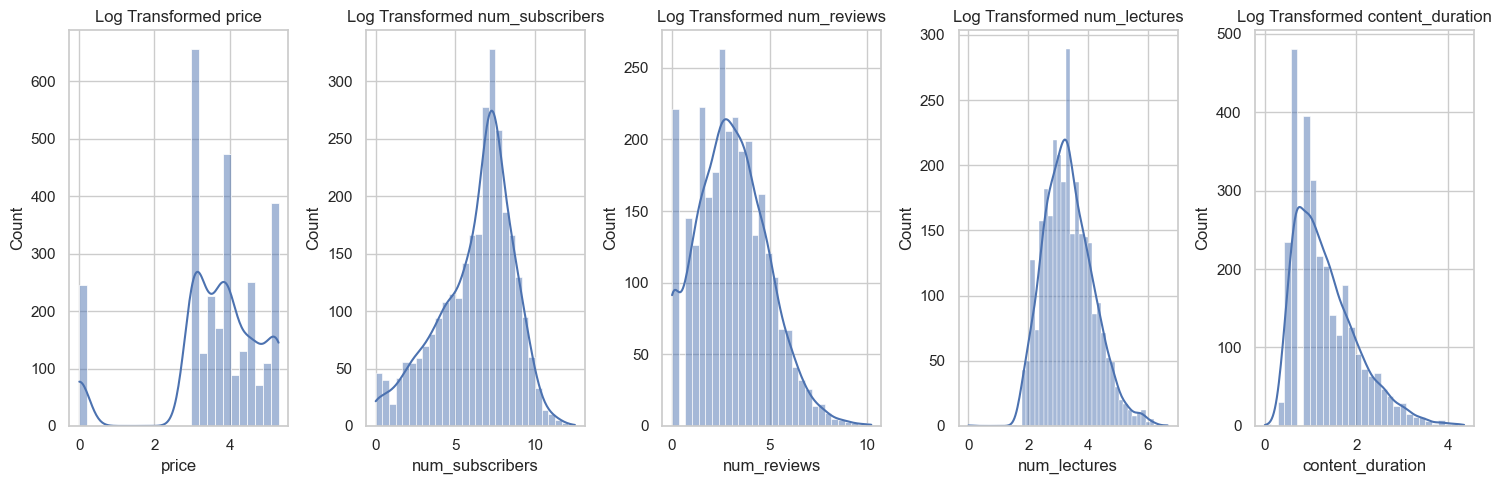

In [10]:
# Select numerical variables for transformation
numerical_vars = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']

# Log transformation of numerical features to normalize skewed data
train_set_encoded[numerical_vars] = train_set_encoded[numerical_vars].apply(lambda x: np.log1p(x))
test_set_encoded[numerical_vars] = test_set_encoded[numerical_vars].apply(lambda x: np.log1p(x))

# Visualize the transformed distributions
fig, axes = plt.subplots(1, len(numerical_vars), figsize=(15, 5))
for i, var in enumerate(numerical_vars):
    sns.histplot(train_set_encoded[var], kde=True, ax=axes[i])
    axes[i].set_title(f"Log Transformed {var}")
plt.tight_layout()
plt.show()

### 6. Handle Outliers with Winsorization

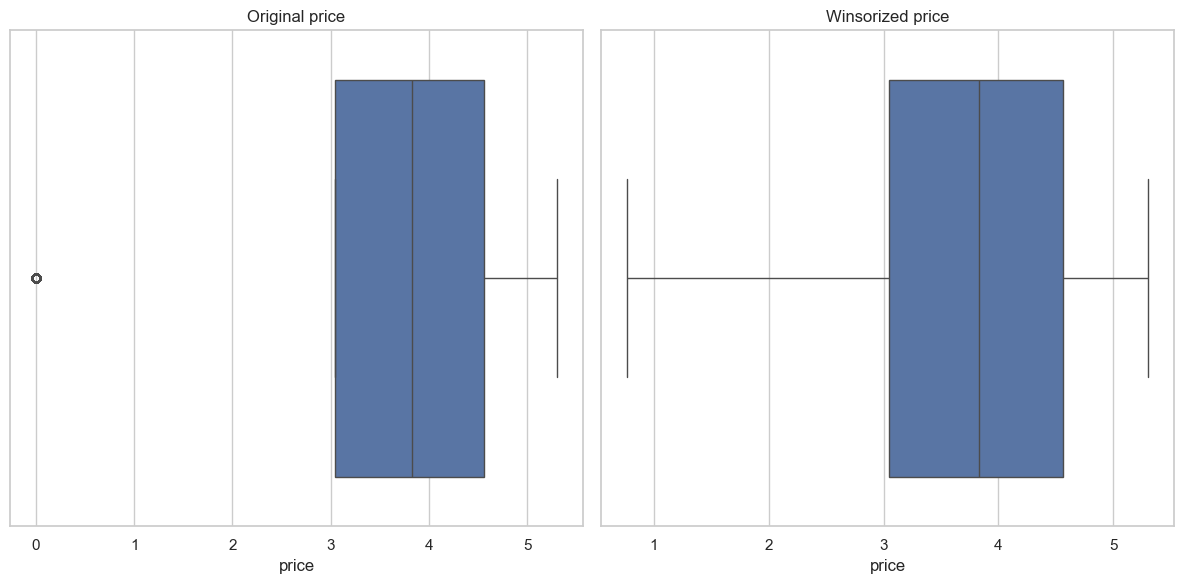

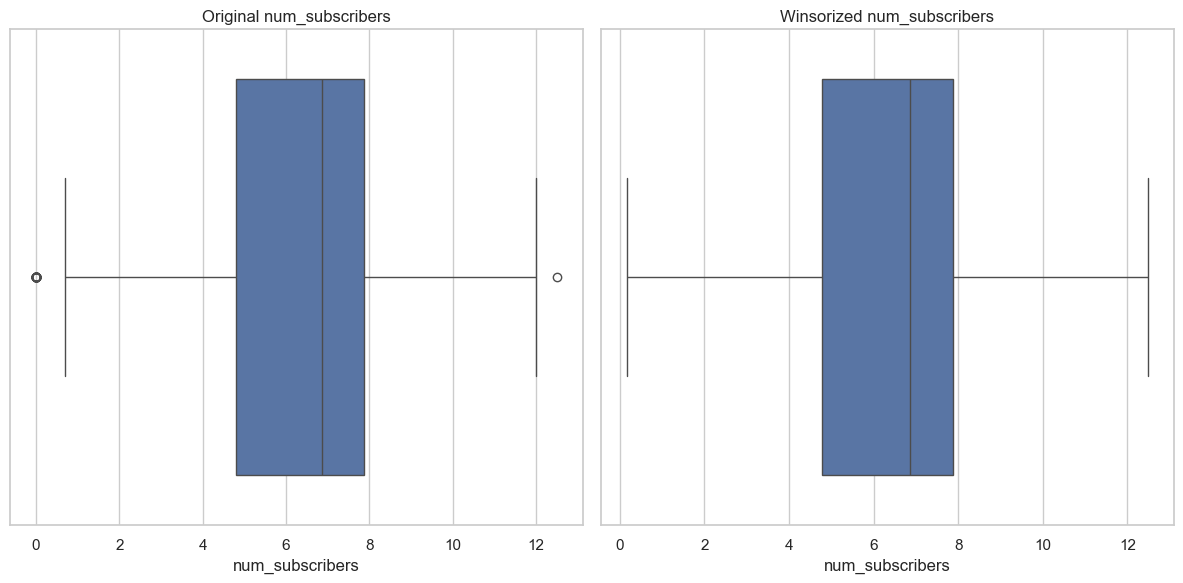

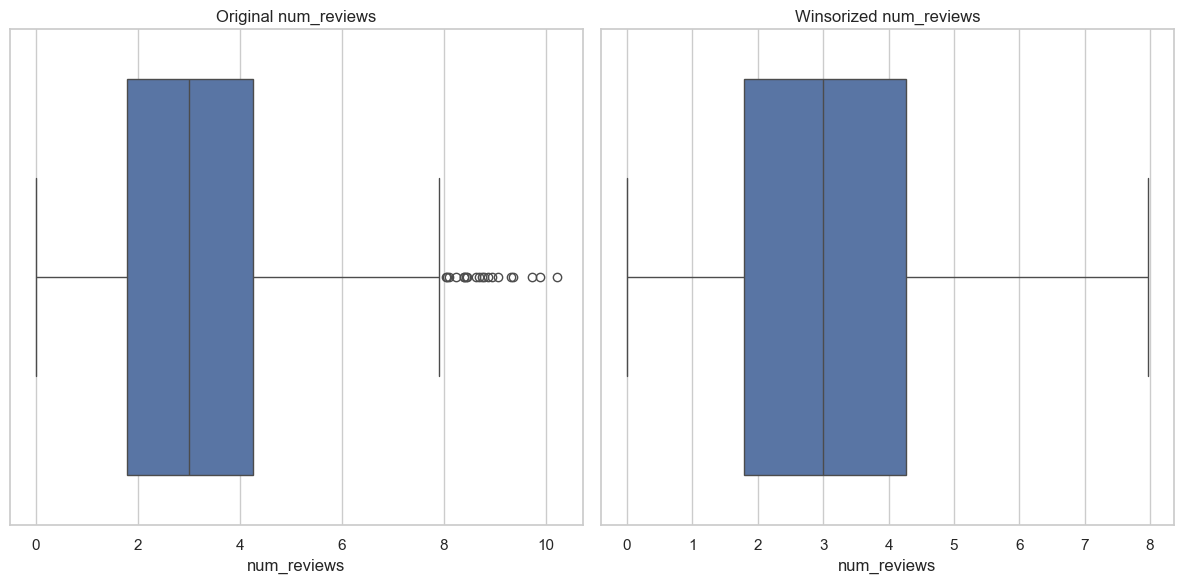

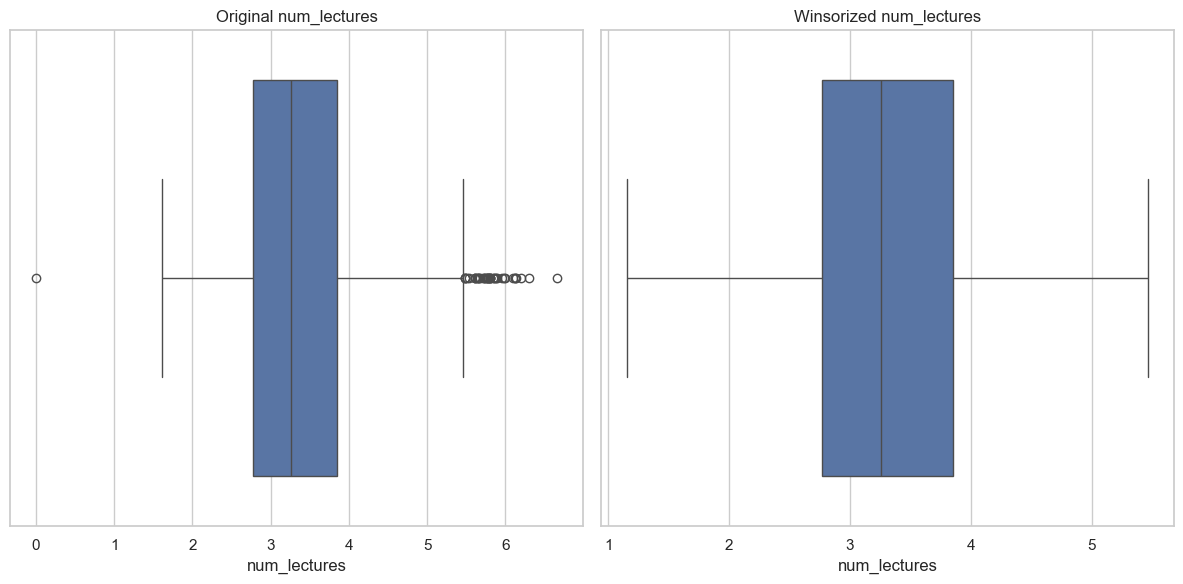

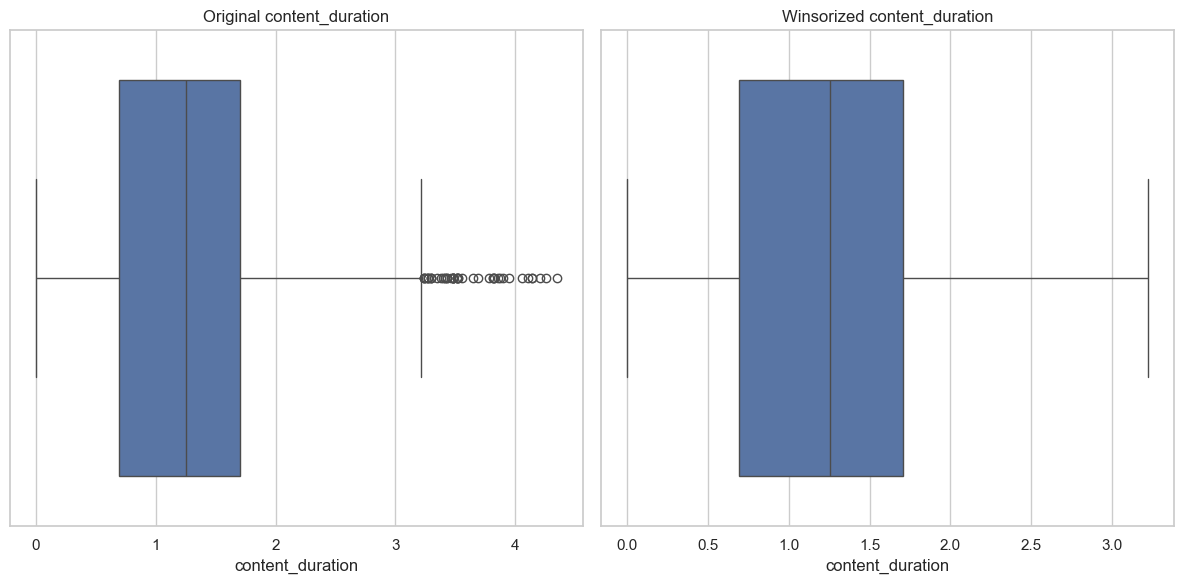

In [12]:
# Apply Winsorizer to handle outliers in numerical columns
winsorizer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=numerical_vars)
train_set_winsorized = winsorizer.fit_transform(train_set_encoded)
test_set_winsorized = winsorizer.transform(test_set_encoded)

# Visualize the effect of Winsorization
for var in numerical_vars:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(x=train_set_encoded[var], ax=ax[0]).set_title(f"Original {var}")
    sns.boxplot(x=train_set_winsorized[var], ax=ax[1]).set_title(f"Winsorized {var}")
    plt.tight_layout()
    plt.show()

### 7. Feature Selection Using Correlation

In [15]:
# Apply Smart Correlated Selection to remove highly correlated features
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")
train_set_selected = corr_sel.fit_transform(train_set_winsorized)

# Display the selected features after removing correlated ones
corr_sel.correlated_feature_sets_, corr_sel.features_to_drop_

([{'num_reviews', 'num_subscribers'}, {'content_duration', 'num_lectures'}],
 ['num_reviews', 'content_duration'])